NearPy

In [1]:
import numpy

from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections

# Dimension of our vector space
dimension = 500

# Create a random binary hash with 10 bits
rbp = RandomBinaryProjections('rbp', 10)

# Create engine with pipeline configuration
engine = Engine(dimension, lshashes=[rbp])

# Index 1000000 random vectors (set their data to a unique string)
for index in range(100000):
    v = numpy.random.randn(dimension)
    engine.store_vector(v, 'data_%d' % index)

# Create random query vector
query = numpy.random.randn(dimension)

# Get nearest neighbours
N = engine.neighbours(query)

In [5]:
s = numpy.array(query)
s.shape

(500,)

Annoy

In [1]:
from annoy import AnnoyIndex
import random

f = 40  # Length of item vector that will be indexed

t = AnnoyIndex(f, 'angular')
for i in range(1000):
    v = [random.gauss(0, 1) for z in range(f)]
    t.add_item(i, v)

t.build(10) # 10 trees
t.save('test.ann')

# ...

u = AnnoyIndex(f, 'angular')
u.load('test.ann') # super fast, will just mmap the file
print(u.get_nns_by_item(0, 1000)) # will find the 1000 nearest neighbors

[0, 299, 783, 138, 134, 701, 263, 542, 706, 265, 947, 152, 857, 866, 619, 401, 842, 810, 404, 852, 200, 245, 724, 418, 296, 889, 443, 289, 478, 10, 117, 21, 393, 435, 928, 73, 313, 184, 174, 667, 338, 620, 862, 513, 747, 583, 462, 8, 288, 142, 6, 756, 499, 55, 909, 762, 307, 388, 982, 98, 133, 422, 409, 412, 329, 640, 37, 846, 123, 243, 548, 171, 833, 369, 790, 179, 259, 344, 165, 869, 792, 323, 405, 748, 904, 588, 399, 932, 755, 919, 631, 428, 643, 339, 408, 912, 684, 148, 670, 940, 127, 486, 204, 427, 436, 955, 613, 485, 994, 582, 562, 837, 564, 353, 230, 557, 26, 11, 809, 332, 34, 784, 229, 429, 646, 598, 29, 466, 954, 985, 13, 203, 512, 558, 99, 167, 733, 41, 45, 205, 592, 849, 357, 227, 207, 50, 717, 854, 695, 610, 545, 781, 704, 293, 908, 51, 261, 459, 506, 630, 71, 451, 941, 32, 552, 578, 268, 725, 820, 282, 47, 929, 398, 633, 563, 699, 885, 278, 2, 693, 146, 894, 479, 708, 503, 944, 441, 795, 709, 872, 219, 48, 108, 825, 199, 779, 120, 718, 745, 816, 333, 137, 304, 413, 49, 106

In [6]:
import os
from urllib.request import urlretrieve
import annoy
import random
import PIL.Image, PIL.ImageOps
import numpy
import util

annoy_fn = 'mnist.annoy'
data_fn = 'mnist.pkl.gz'

if not os.path.exists(annoy_fn):
    if not os.path.exists(data_fn):
        print ('downloading')
        urlretrieve('http://deeplearning.net/data/mnist/mnist.pkl.gz', data_fn)

    a = annoy.AnnoyIndex(784, 'euclidean')
    for i, pic in util.get_vectors(data_fn):
        a.add_item(i, pic)

    print ('building')
    a.build(10)
    a.save(annoy_fn)

a = annoy.AnnoyIndex(784, 'euclidean')
a.load(annoy_fn)

pics = 5
nns = 10
img_size = 100
margin = 16

main_image = PIL.Image.new('RGB', (img_size * nns + margin, img_size * pics), 'white')

for pic in range(pics):
    i = random.randint(0, a.get_n_items() - 1)
    for index, j in enumerate(a.get_nns_by_item(i, 10, 1000)):
        v = a.get_item_vector(j)
        w = (numpy.array(v)*255).astype(numpy.uint8).reshape(28, 28)
        image = PIL.Image.fromarray(w)
        image = PIL.ImageOps.fit(image, (img_size, img_size)) # , PIL.Image.ANTIALIAS)
        if index == 0:
            image.save('seed.jpg')
        
        main_image.paste(image, (index * img_size + margin * int(index > 0), pic * img_size))

main_image.save('mnist_strips.jpg')

ModuleNotFoundError: No module named 'util'

HNSW

In [2]:
import hnswlib
import numpy as np
import pickle

dim = 128
num_elements = 10000

# Generating sample data
data = np.float32(np.random.random((num_elements, dim)))
ids = np.arange(num_elements)

# Declaring index
p = hnswlib.Index(space = 'l2', dim = dim) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = num_elements, ef_construction = 200, M = 16)

# Element insertion (can be called several times):
p.add_items(data, ids)

# Controlling the recall by setting ef:
p.set_ef(50) # ef should always be > k

# Query dataset, k - number of the closest elements (returns 2 numpy arrays)
labels, distances = p.knn_query(data, k = 1)

# Index objects support pickling
# WARNING: serialization via pickle.dumps(p) or p.__getstate__() is NOT thread-safe with p.add_items method!
# Note: ef parameter is included in serialization; random number generator is initialized with random_seed on Index load
p_copy = pickle.loads(pickle.dumps(p)) # creates a copy of index p using pickle round-trip

### Index parameters are exposed as class properties:
print(f"Parameters passed to constructor:  space={p_copy.space}, dim={p_copy.dim}") 
print(f"Index construction: M={p_copy.M}, ef_construction={p_copy.ef_construction}")
print(f"Index size is {p_copy.element_count} and index capacity is {p_copy.max_elements}")
print(f"Search speed/quality trade-off parameter: ef={p_copy.ef}")

Parameters passed to constructor:  space=l2, dim=128
Index construction: M=16, ef_construction=200
Index size is 10000 and index capacity is 10000
Search speed/quality trade-off parameter: ef=50


datasketch

In [1]:
from datasketch import MinHash, MinHashLSH

set1 = set(['minhash', 'is', 'a', 'probabilistic', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'datasets'])
set2 = set(['minhash', 'is', 'a', 'probability', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'documents'])
set3 = set(['minhash', 'is', 'probability', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'documents'])

m1 = MinHash(num_perm=128)
m2 = MinHash(num_perm=128)
m3 = MinHash(num_perm=128)
for d in set1:
    m1.update(d.encode('utf8'))
for d in set2:
    m2.update(d.encode('utf8'))
for d in set3:
    m3.update(d.encode('utf8'))

# Create LSH index
lsh = MinHashLSH(threshold=0.5, num_perm=128)
lsh.insert("m2", m2)
lsh.insert("m3", m3)
result = lsh.query(m1)
print("Approximate neighbours with Jaccard similarity > 0.5", result)

Approximate neighbours with Jaccard similarity > 0.5 ['m3', 'm2']


In [1]:
import os 
os.getenv('PATH')

'c:\\Users\\Acer\\AppData\\Local\\Programs\\Python\\Python39;c:\\Users\\Acer\\AppData\\Roaming\\Python\\Python39\\Scripts;C:\\Users\\Acer\\anaconda3;C:\\Users\\Acer\\anaconda3\\Library\\mingw-w64\\bin;C:\\Users\\Acer\\anaconda3\\Library\\usr\\bin;C:\\Users\\Acer\\anaconda3\\Library\\bin;C:\\Users\\Acer\\anaconda3\\Scripts;C:\\Users\\Acer\\anaconda3\\bin;C:\\Users\\Acer\\anaconda3\\condabin;C:\\Users\\Acer\\anaconda3;C:\\Users\\Acer\\anaconda3\\Library\\mingw-w64\\bin;C:\\Users\\Acer\\anaconda3\\Library\\usr\\bin;C:\\Users\\Acer\\anaconda3\\Library\\bin;C:\\Users\\Acer\\anaconda3\\Scripts;C:\\Users\\Acer\\anaconda3;C:\\Users\\Acer\\anaconda3\\Library\\mingw-w64\\bin;C:\\Users\\Acer\\anaconda3\\Library\\usr\\bin;C:\\Users\\Acer\\anaconda3\\Library\\bin;C:\\Users\\Acer\\anaconda3\\Scripts;C:\\Users\\Acer\\anaconda3\\bin;C:\\Windows;C:\\Windows\\system32;C:\\Windows\\system32\\Wbem;C:\\Users\\Acer\\anaconda3;C:\\Users\\Acer\\anaconda3\\Library\\mingw-w64\\bin;C:\\Users\\Acer\\anaconda3\\Li

Faiss

In [1]:
import numpy as np
import faiss
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits

In [2]:
digits = load_digits()
print("Image Data Shape" , digits.data.shape)
def draw_mnist(arr):
    plt.figure(figsize=(len(arr)*4,4))
    for index, (image) in enumerate(zip(arr)):
        plt.subplot(1, len(arr), index + 1)
        plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)

Image Data Shape (1797, 64)


In [3]:
# mnist indexing
d = 64                           # dimension
nb = 100                      # database size
nq = 10                     # nb of queries

xb = digits.data.astype('float32') 
xq = digits.data[0:1].astype('float32') # Use the first image as the query vector

print('xb.shape : ', xb.shape, '\nxq.shape : ', xq.shape)

xb.shape :  (1797, 64) 
xq.shape :  (1, 64)


In [4]:
index = faiss.IndexFlatL2(d)   # build the index
print('index.is_trained : ', index.is_trained)

index.add(xb)                  # add vectors to the index
print('index.ntotal : ', index.ntotal)

index.is_trained :  True
index.ntotal :  1797


In [5]:
k = 10                          # we want to see top k nearest neighbors (the first result will always be the query vector)
D, I = index.search(xq, k)     # actual search
print('I[:5] : ', I[:k])                   # neighbors of the 5 first queries
print('D[:5] : ', D[:k])                   # distances of the 5 first queries

I[:5] :  [[   0  877 1365 1541 1167 1029  464  957 1697  855]]
D[:5] :  [[  0. 120. 164. 172. 176. 178. 181. 238. 245. 252.]]


In [6]:
arr = np.empty([0,64])
i = 0
for i in range(k):
    print('index : ', I[0,i], '\ndistance : ', D[0,i], '\narr : ', xb[I[0,i]])
    arr = np.vstack((arr, xb[I[0,i]]))
print('arr.shape : ', arr.shape)

index :  0 
distance :  0.0 
arr :  [ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
index :  877 
distance :  120.0 
arr :  [ 0.  0.  7. 13.  8.  4.  0.  0.  0.  1. 15. 11.  9. 15.  2.  0.  0.  4.
 16.  6.  0.  8.  7.  0.  0.  4. 10.  0.  0.  7.  8.  0.  0.  4. 10.  0.
  0.  8.  8.  0.  0.  5. 12.  0.  0. 12.  5.  0.  0.  3. 15.  5.  9. 14.
  2.  0.  0.  0.  8. 14. 12.  3.  0.  0.]
index :  1365 
distance :  164.0 
arr :  [ 0.  0.  5. 13. 11.  1.  0.  0.  0.  3. 16. 11.  8. 12.  0.  0.  0.  5.
 16.  0.  0. 13.  3.  0.  0.  5. 13.  0.  0.  6.  7.  0.  0.  7. 10.  0.
  0.  8.  7.  0.  0.  4. 13.  0.  1. 14.  5.  0.  0.  1. 15.  5. 12. 10.
  0.  0.  0.  0.  7. 16. 10.  1.  0.  0.]
index :  1541 
distance :  172.0 
arr :  [ 0.  0.  5. 12.  9.  1.  0.  0.  0.  0. 14. 14. 13. 13.  0

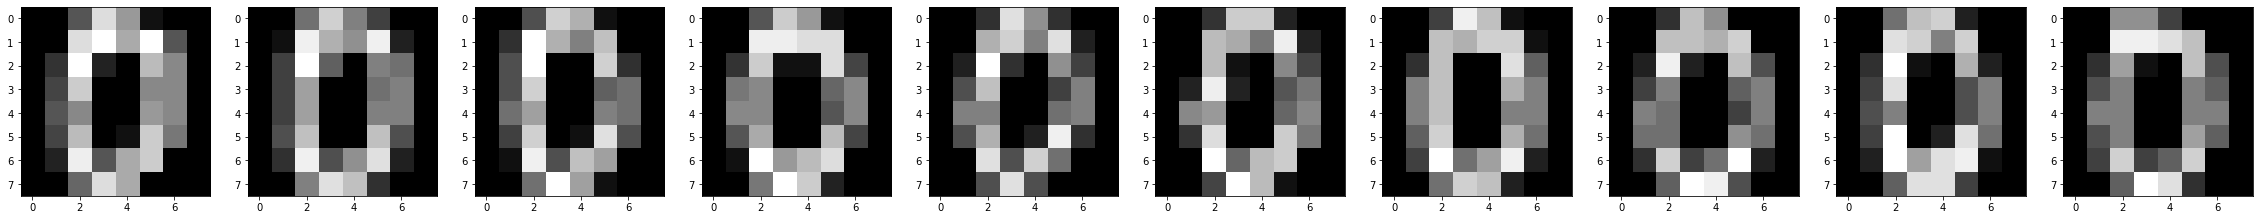

In [7]:
draw_mnist(arr)